In [1]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import binom



##### Analysis of the influence of large market capitalization stocks on the IHSG (Composite Stock Price Index) prices.
---

**Background:**

The IHSG (Composite Stock Price Index) is a benchmark weighted average index of all stocks listed on the Indonesia Stock Exchange. As of May 12, 2024, there are over 800 companies listed on the Indonesian stock exchange.

The calculation formula for IHSG is as follows:

$$
\begin{align*}
IHSG &= \cfrac{Market\ Value}{Base\ Value}{\times\ 100}\\
\end{align*}
$$


The market value is equivalent to the market capitalization, which can be calculated using the following formula:

$$
Market\ Value = p_1 \times q_1 + p_2 \times q_2 + p_3 \times q_3 + ... + p_n \times q_n
$$

Where:

$$
p = Closing\ Price \\
q = Numner\ of\ shares\ outstanding
$$



From the formula above, we can conclude that the market capitalization of a stock can significantly influence the IHSG price. Therefore, the larger the market capitalization of a stock, the greater its contribution to the daily calculation of the IHSG.







So, in this project, I want to prove that stocks with large market capitalizations can influence IHSG prices.



---

### 1. Import data

In this project, we need two types of data:


1. IHSG price movements
2. Price movements of the top 5 market cap stocks on the Indonesia Stock Exchange







In [15]:
# Scrape the top 5 market cap stocks from Yahoo Finance
kode =yf.download(['BBCA.JK','BYAN.JK','BMRI.JK','BBRI.JK'],start = '2023-01-01',end = '2023-12-31')
print(kode)

[*********************100%***********************]  4 of 4 completed
              Adj Close                                           Close  \
                BBCA.JK      BBRI.JK      BMRI.JK       BYAN.JK BBCA.JK   
Date                                                                      
2023-01-02  8154.728516  4349.535645  4469.157227  20636.699219  8550.0   
2023-01-03  8154.728516  4331.672852  4503.100586  20685.255859  8550.0   
2023-01-04  7963.974609  4260.222656  4537.043457  20515.308594  8350.0   
2023-01-05  7868.597656  4144.116211  4446.528809  19398.496094  8250.0   
2023-01-06  7916.286621  4126.253418  4435.214844  19981.181641  8300.0   
...                 ...          ...          ...           ...     ...   
2023-12-21  9114.956055  5291.497070  5684.292480  19525.000000  9325.0   
2023-12-22  9114.956055  5386.412109  5684.292480  19500.000000  9325.0   
2023-12-27  9163.830078  5338.954590  5708.076172  19300.000000  9375.0   
2023-12-28  9188.267578  5433.8

In [16]:
# Create a PD DataFrame from top 5 market cap stock data
big_cap = {'BBRI':kode[('Close', 'BBRI.JK')],'BBCA':kode[('Close', 'BBCA.JK')],'BYAN':kode[('Close', 'BYAN.JK')],'BMRI':kode[('Close', 'BMRI.JK')]}
data_bigcap_2023=pd.DataFrame(big_cap)
data_bigcap_2023.reset_index(inplace=True)
data_bigcap_2023.head()

,Date,BBRI,BBCA,BYAN,BMRI
0,2023-01-02,4870.0,8550.0,21250.0,4937.5
1,2023-01-03,4850.0,8550.0,21300.0,4975.0
2,2023-01-04,4770.0,8350.0,21125.0,5012.5
3,2023-01-05,4640.0,8250.0,19975.0,4912.5
4,2023-01-06,4620.0,8300.0,20575.0,4900.0


In [17]:
#Load IHSG data after retrieving it from the Yahoo Finance website
#Transform the data into a list to be added to the previous dataframe
ihsg = pd.read_csv('^JKSE.csv')
ihsg = ihsg[ihsg['Date']>='2023-01-01']['Close']
ihsg_list = ihsg.to_list()
ihsg_list

[6850.983887,
 6888.757813,
 6813.23877,
 6653.84082,
 6684.558105,
 6688.265137,
 6622.499023,
 6584.453125,
 6629.934082,
 6641.830078,
 6688.057129,
 6767.339844,
 6765.786133,
 6819.907227,
 6874.931152,
 6860.854004,
 6829.930176,
 6864.817871,
 6898.980957,
 6872.480957,
 6839.341797,
 6862.257813,
 6890.571777,
 6911.731934,
 6873.791016,
 6935.300781,
 6940.124023,
 6897.365234,
 6880.329102,
 6900.140137,
 6941.85498,
 6914.538086,
 6895.664063,
 6895.713867,
 6894.716797,
 6873.404785,
 6809.967773,
 6839.454102,
 6856.576172,
 6854.776855,
 6843.23877,
 6844.936035,
 6857.415039,
 6813.63623,
 6807.000977,
 6766.757813,
 6776.370117,
 6799.794922,
 6765.301758,
 6786.955078,
 6641.813965,
 6628.137207,
 6565.728027,
 6678.236816,
 6612.490234,
 6691.61084,
 6762.253906,
 6708.933105,
 6760.328125,
 6839.436035,
 6808.951172,
 6805.276855,
 6827.174805,
 6833.178223,
 6819.674805,
 6792.765137,
 6771.234863,
 6811.313965,
 6798.963867,
 6785.598145,
 6818.574219,
 6787.582031

In [18]:
#Insert IHSG prices into the existing dataframe and make a copy of the dataframe to later calculate the percentage change
data_bigcap_2023['IHSG']=ihsg_list
data_copy = data_bigcap_2023.copy()
data_copy

,Date,BBRI,BBCA,BYAN,BMRI,IHSG
0,2023-01-02,4870.0,8550.0,21250.0,4937.5,6850.983887
1,2023-01-03,4850.0,8550.0,21300.0,4975.0,6888.757813
2,2023-01-04,4770.0,8350.0,21125.0,5012.5,6813.238770
3,2023-01-05,4640.0,8250.0,19975.0,4912.5,6653.840820
4,2023-01-06,4620.0,8300.0,20575.0,4900.0,6684.558105
...,...,...,...,...,...,...
234,2023-12-21,5575.0,9325.0,19525.0,5975.0,7209.619141
235,2023-12-22,5675.0,9325.0,19500.0,5975.0,7237.519043
236,2023-12-27,5625.0,9375.0,19300.0,6000.0,7245.916016
237,2023-12-28,5725.0,9400.0,19825.0,6125.0,7303.888184


In [19]:
# exclude date columns
data_nodate = data_bigcap_2023.loc[:,'BBRI':]

for i in data_nodate.columns:
        data_nodate[i]=pd.DataFrame(data_nodate[i].pct_change()*100)

data_nodate.head()

,BBRI,BBCA,BYAN,BMRI,IHSG
0,NaN,NaN,NaN,NaN,NaN
1,-0.410678,0.000000,0.235294,0.759494,0.551365
2,-1.649485,-2.339181,-0.821596,0.753769,-1.096265
3,-2.725367,-1.197605,-5.443787,-1.995012,-2.339533
4,-0.431034,0.606061,3.003755,-0.254453,0.461647


## Descriptive Analyst

In [20]:
data_copy

,Date,BBRI,BBCA,BYAN,BMRI,IHSG
0,2023-01-02,4870.0,8550.0,21250.0,4937.5,6850.983887
1,2023-01-03,4850.0,8550.0,21300.0,4975.0,6888.757813
2,2023-01-04,4770.0,8350.0,21125.0,5012.5,6813.238770
3,2023-01-05,4640.0,8250.0,19975.0,4912.5,6653.840820
4,2023-01-06,4620.0,8300.0,20575.0,4900.0,6684.558105
...,...,...,...,...,...,...
234,2023-12-21,5575.0,9325.0,19525.0,5975.0,7209.619141
235,2023-12-22,5675.0,9325.0,19500.0,5975.0,7237.519043
236,2023-12-27,5625.0,9375.0,19300.0,6000.0,7245.916016
237,2023-12-28,5725.0,9400.0,19825.0,6125.0,7303.888184


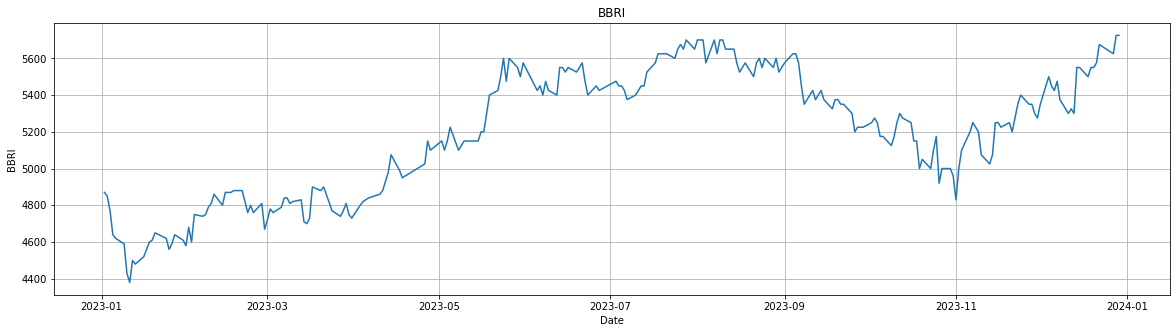

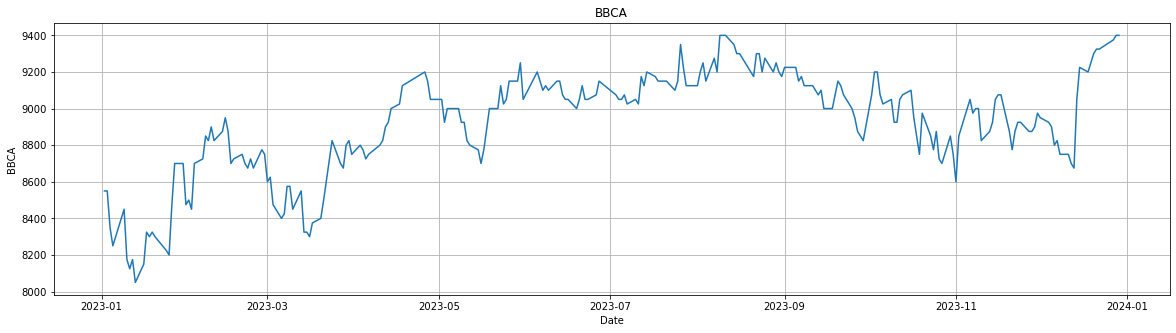

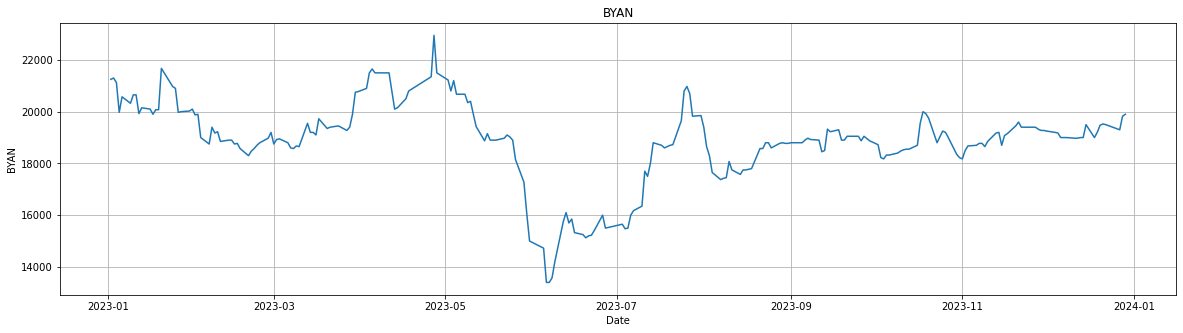

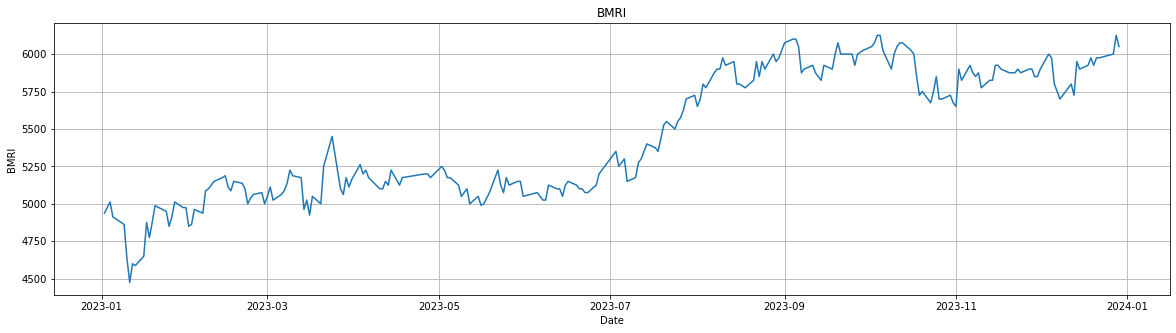

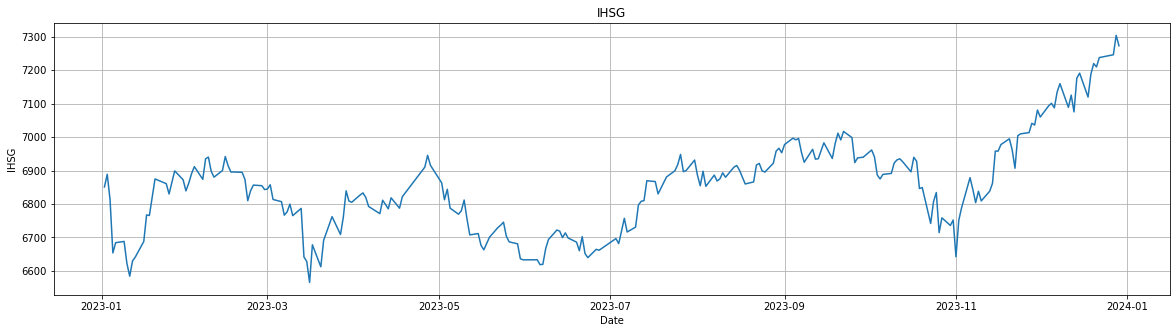

In [21]:
# View stock price movements during the year 2023
for kolom in data_bigcap_2023.columns:
    if kolom != 'Date':
        plt.figure(figsize=(20,5))
        plt.grid()
        sns.lineplot(data=data_copy,x='Date',y=kolom )
        plt.title(kolom)
        plt.show()

 - From the stock price movements above, it can be concluded that;

    - **IHSG**: Moved sideways initially and started an uptrend in November.
    - **BMRI**: Already began an uptrend and rallied from Q1 2023.
    - **BYAN**: Tended to stagnate and exhibited highly volatile prices.
    - **BBCA**: Started moving upwards from Q1 2023.
    - **BBRI**: Started moving upwards from Q1 2023.

In [22]:
# Stock change YTD
ytd_results = {}

for column in data_bigcap_2023.columns:
    if column != 'Date':
        ytd_results[column] = ((data_copy[column].iloc[-1] - data_copy[column].iloc[0]) / data_copy[column].iloc[0]) * 100

# Printing the results
for column, ytd in ytd_results.items():
    print(f"{column}: {ytd: .2f}%")

BBRI:  17.56%
BBCA:  9.94%
BYAN: -6.35%
BMRI:  22.53%
IHSG:  6.16%


In the data above, it can be seen that almost all stocks experienced a year-to-date increase except for BYAN.

In [23]:
# All time high value from each 
data_bigcap_2023.describe()

,BBRI,BBCA,BYAN,BMRI,IHSG
count,239.000000,239.000000,239.000000,239.000000,239.000000
mean,5192.510460,8914.958159,18877.615063,5459.424686,6856.961287
std,345.973196,291.436961,1555.834425,426.735346,139.436178
min,4380.000000,8050.000000,13400.000000,4475.000000,6565.728027
25%,4870.000000,8750.000000,18575.000000,5100.000000,6761.291015
50%,5250.000000,9000.000000,18975.000000,5300.000000,6860.854004
75%,5500.000000,9125.000000,19625.000000,5900.000000,6932.861084
max,5725.000000,9400.000000,22950.000000,6125.000000,7303.888184


## Analysis on Discreate Variable

In [24]:
data_nodate=data_nodate.loc[1:]

In [25]:
# The probability on the stock prices goes up, down or stay put
stock_proba = []
for i in data_nodate.columns:
    proba_postive=len(data_nodate[data_nodate[i]>0][i])/len(data_nodate)
    proba_negative = len(data_nodate[data_nodate[i]<0][i])/len(data_nodate)
    proba_tetap = len(data_nodate[data_nodate[i]==0][i])/len(data_nodate)
    stock_proba.append({'Stock name': i,'Proba positive':proba_postive,'proba negative':proba_negative,'proba stay':proba_tetap})

df_stock_proba = pd.DataFrame(stock_proba)

df_stock_proba

,Stock name,Proba positive,proba negative,proba stay
0,BBRI,0.474790,0.403361,0.121849
1,BBCA,0.420168,0.432773,0.147059
2,BYAN,0.470588,0.407563,0.121849
3,BMRI,0.491597,0.407563,0.100840
4,IHSG,0.550420,0.449580,0.000000


In [26]:
proba_ihsg_positive = data_nodate[data_nodate['IHSG'] > 0]
proba_ihsg_negative = data_nodate[data_nodate['IHSG'] < 0]

In [27]:
# Probability of price changes for the four stocks with the largest market capitalization on the Indonesia Stock Exchanges
# Goes down
stock_proba_down = []
for i in proba_ihsg_negative.columns:
        proba_postive=len(proba_ihsg_negative[proba_ihsg_negative[i]>0][i])/len(proba_ihsg_negative)
        proba_negative = len(proba_ihsg_negative[proba_ihsg_negative[i]<0][i])/len(proba_ihsg_negative)
        proba_tetap = len(proba_ihsg_negative[proba_ihsg_negative[i]==0][i])/len(proba_ihsg_negative)
        stock_proba_down.append({'Stock name': i,'Proba positive':proba_postive,'proba negative':proba_negative,'proba stay':proba_tetap})

df_stock_proba_ihsgdown = pd.DataFrame(stock_proba_down)

df_stock_proba_ihsgdown

,Stock name,Proba positive,proba negative,proba stay
0,BBRI,0.308411,0.570093,0.121495
1,BBCA,0.280374,0.560748,0.158879
2,BYAN,0.327103,0.570093,0.102804
3,BMRI,0.280374,0.598131,0.121495
4,IHSG,0.000000,1.000000,0.000000


In [28]:
# Probability of price changes for the four stocks with the largest market capitalization on the indonesia stock exchange prices
# Goes up
stock_proba = []
for i in proba_ihsg_positive.columns:
        proba_postive=len(proba_ihsg_positive[proba_ihsg_positive[i]>0][i])/len(proba_ihsg_positive)
        proba_negative = len(proba_ihsg_positive[proba_ihsg_positive[i]<0][i])/len(proba_ihsg_positive)
        proba_tetap = len(proba_ihsg_positive[proba_ihsg_positive[i]==0][i])/len(proba_ihsg_positive)
        stock_proba.append({'Stock name': i,'Proba positive':proba_postive,'proba negative':proba_negative,'proba tetap':proba_tetap})

df_stock_proba_ihsgup = pd.DataFrame(stock_proba)

df_stock_proba_ihsgup

,Stock name,Proba positive,proba negative,proba tetap
0,BBRI,0.610687,0.267176,0.122137
1,BBCA,0.534351,0.328244,0.137405
2,BYAN,0.587786,0.274809,0.137405
3,BMRI,0.664122,0.251908,0.083969
4,IHSG,1.000000,0.000000,0.000000


In [29]:
# Probability of IHSG increasing
# Can use binomial distribution
# Where the Bernoulli distribution tells about the probability of success in an event

print(f'The probability of IHSG rising for 5 days in one month {round(binom.pmf(5,20,0.5),2)}')
print(f'The probability of IHSG rising for 10 days in one month {round(binom.pmf(10,20,0.5),2)}')
print(f'The probability of IHSG rising for 15 days in one month {round(binom.pmf(12,20,0.5),2)}')



The probability of IHSG rising for 5 days in one month 0.01
The probability of IHSG rising for 10 days in one month 0.18
The probability of IHSG rising for 15 days in one month 0.12


## Analysis of Continuous Variables

In [30]:
diff_price = pd.DataFrame()

for i in data_bigcap_2023.columns:
    if i != 'Date':
        diff_price[i] = data_bigcap_2023[i].diff()


diff_price.dropna(inplace=True)
diff_price


,BBRI,BBCA,BYAN,BMRI,IHSG
1,-20.0,0.0,50.0,37.5,37.773926
2,-80.0,-200.0,-175.0,37.5,-75.519043
3,-130.0,-100.0,-1150.0,-100.0,-159.397950
4,-20.0,50.0,600.0,-12.5,30.717285
5,-30.0,150.0,-250.0,-37.5,3.707032
...,...,...,...,...,...
234,25.0,25.0,50.0,50.0,-10.047851
235,100.0,0.0,-25.0,0.0,27.899902
236,-50.0,50.0,-200.0,25.0,8.396973
237,100.0,25.0,525.0,125.0,57.972168


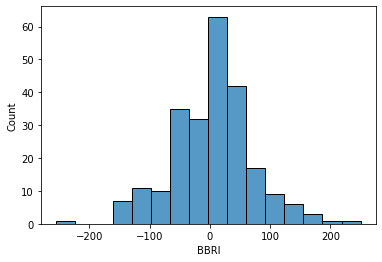

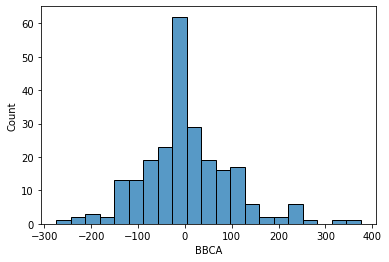

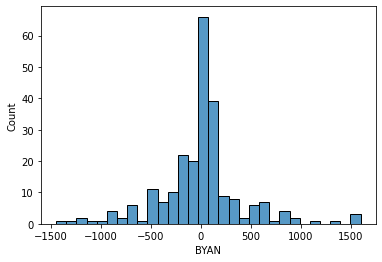

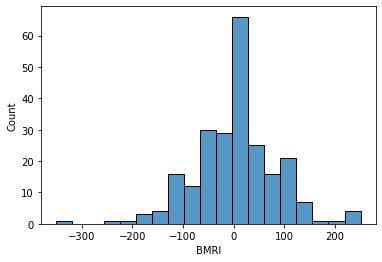

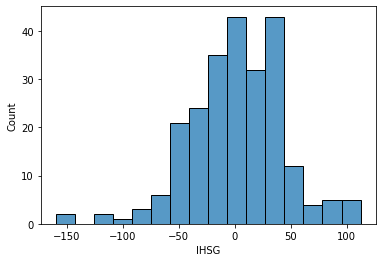

In [31]:
for col in diff_price.columns:
    sns.histplot(data=diff_price[col])
    plt.show()

In [32]:
mean = round(diff_price['BBRI'].mean(),3)
var = round(diff_price['BBRI'].var(),3)

print('mean:',mean,'var:',var)

mean: 3.592 var: 4716.681


In [33]:
diff_price['BYAN'].min()

-1450.0

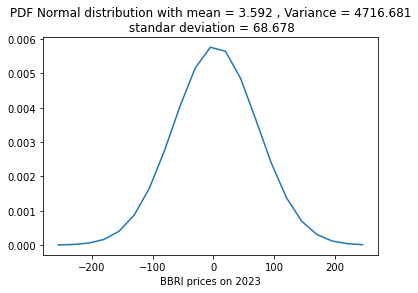

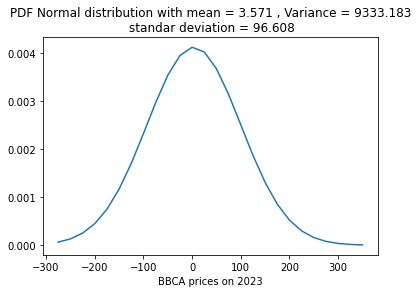

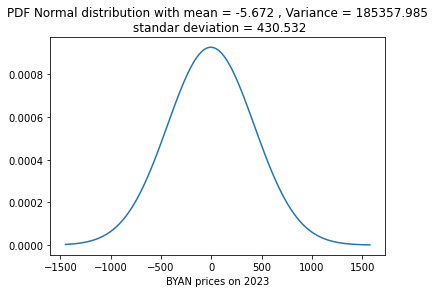

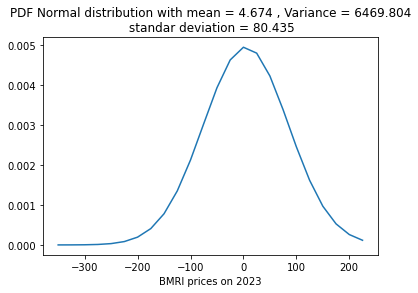

In [34]:
def pdf_normal(x, mu, var):
    return (1 / np.sqrt(2 * np.pi * var)) *\
        np.exp(-(1 / (2 * var)) * (x - mu) ** 2)




for col in diff_price.columns:
    if col != 'IHSG':
        if col == 'TLKM':
            mean = round(diff_price[col].mean(),3)
            var_ = round(diff_price[col].var(),3)
            x_axis = np.arange(diff_price[col].min(), diff_price[col].max(), 10)
            y_axis = pdf_normal(x_axis, mean, var_)
            plt.plot(x_axis, y_axis)
            #plt.ylim(0,0.6)
            plt.xlabel(f" {col} prices on 2023")
            plt.title('PDF Normal distribution with mean = '+str(mean)+' , Variance = '+str(var_)+'\n standar deviation = ' + str(np.round(np.sqrt(var_),3)))
            plt.show()
        else:
            mean = round(diff_price[col].mean(),3)
            var_ = round(diff_price[col].var(),3)
            x_axis = np.arange(diff_price[col].min(), diff_price[col].max(), 25)
            y_axis = pdf_normal(x_axis, mean, var_)
            plt.plot(x_axis, y_axis)
            #plt.ylim(0,0.6)
            plt.xlabel(f"{col} prices on 2023")
            plt.title('PDF Normal distribution with mean = '+str(mean)+' , Variance = '+str(var_)+'\n standar deviation = ' + str(np.round(np.sqrt(var_),3)))
            plt.show()

In [35]:
def mean_(kode):
    return round(diff_price[kode].mean(),3)

def var_(kode):
    return round(diff_price[kode].var(),3)

In [36]:
diff_price.columns

Index(['BBRI', 'BBCA', 'BYAN', 'BMRI', 'IHSG'], dtype='object')

In [37]:
# The probability on every stocks prices decrease
peluang_turun = {}
for col in diff_price.columns:
    x = 0
    std = np.sqrt(var_(col))
    X = (x-mean_(col))/std
    peluang_turun[col]= norm.cdf(X,mean_(col),std)

for x,y in peluang_turun.items():
    print(f'Probability of {x} prices decrease is {round(y,2)} ')

Probability of BBRI prices decrease is 0.48 
Probability of BBCA prices decrease is 0.49 
Probability of BYAN prices decrease is 0.51 
Probability of BMRI prices decrease is 0.48 
Probability of IHSG prices decrease is 0.48 


In [38]:
# The probability every stocks prices increase for 100 point
p100={}
for col in diff_price.columns:
    x = 100
    mean = mean_(col)
    std = np.sqrt(var_(col))
    p100[col] = 1-norm.cdf(x,mean,std)

for x,y in p100.items():
    print(f'Probability of {x} prices increase more than 100 points is {round(y,2)}')

Probability of BBRI prices increase more than 100 points is 0.08
Probability of BBCA prices increase more than 100 points is 0.16
Probability of BYAN prices increase more than 100 points is 0.4
Probability of BMRI prices increase more than 100 points is 0.12
Probability of IHSG prices increase more than 100 points is 0.01


In [39]:
# Probability stock prices increasee on 0 - 50 points

x1 = 0
x2 = 50
p = {}

for col in diff_price.columns:

    mean = mean_(col)
    std = np.sqrt(var_(col))
    p0 = norm.cdf(x1,mean,std)
    p150 = norm.cdf(x2,mean,std)
    p[col] = p150-p0


for x,y in p.items():
    print(f'Probability of {x} prices increase for 0-50 points is {round(y,2)}')

Probability of BBRI prices increase for 0-50 points is 0.27
Probability of BBCA prices increase for 0-50 points is 0.2
Probability of BYAN prices increase for 0-50 points is 0.05
Probability of BMRI prices increase for 0-50 points is 0.24
Probability of IHSG prices increase for 0-50 points is 0.39


## Corelation

In [40]:
data_bigcap_2023

,Date,BBRI,BBCA,BYAN,BMRI,IHSG
0,2023-01-02,4870.0,8550.0,21250.0,4937.5,6850.983887
1,2023-01-03,4850.0,8550.0,21300.0,4975.0,6888.757813
2,2023-01-04,4770.0,8350.0,21125.0,5012.5,6813.238770
3,2023-01-05,4640.0,8250.0,19975.0,4912.5,6653.840820
4,2023-01-06,4620.0,8300.0,20575.0,4900.0,6684.558105
...,...,...,...,...,...,...
234,2023-12-21,5575.0,9325.0,19525.0,5975.0,7209.619141
235,2023-12-22,5675.0,9325.0,19500.0,5975.0,7237.519043
236,2023-12-27,5625.0,9375.0,19300.0,6000.0,7245.916016
237,2023-12-28,5725.0,9400.0,19825.0,6125.0,7303.888184


In [41]:
data_corr=data_bigcap_2023.corr()

<AxesSubplot:>

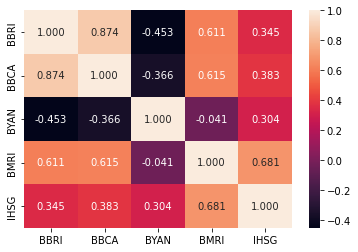

In [42]:
sns.heatmap(data=data_corr,annot=True,fmt='.3f')

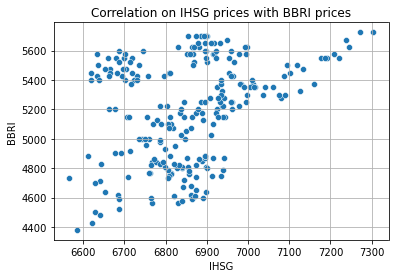

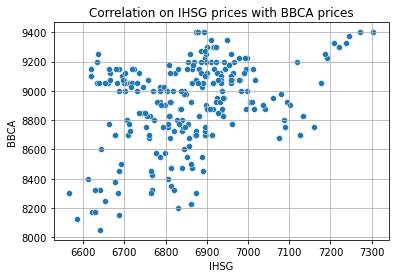

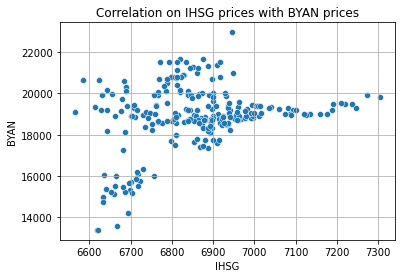

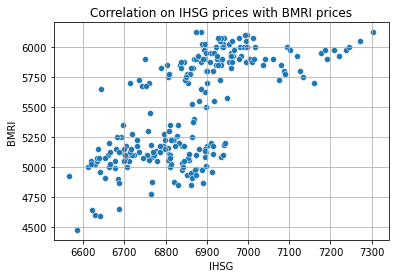

In [43]:
for col in data_bigcap_2023.columns:
    if col != 'Date' and col != 'IHSG':
        sns.scatterplot(data=data_bigcap_2023,x='IHSG',y=col)
        plt.title(f'Correlation on IHSG prices with {col} prices')
        plt.grid()
        plt.show()

## Hypothesis testing
---

$$H_0: \mu_{\ Increasing\ on\ Big\ Cap]} = \mu_{\ Increasing\ on\ IHSG}$$
$$H_1: \mu_{\ Increasing\ on\ Big\ Cap} \not= \mu_{\ Increasing\ on\ IHSG}$$

In [44]:
# Inisiasi niali alpha
alpha = 0.05

In [45]:
diff_price

,BBRI,BBCA,BYAN,BMRI,IHSG
1,-20.0,0.0,50.0,37.5,37.773926
2,-80.0,-200.0,-175.0,37.5,-75.519043
3,-130.0,-100.0,-1150.0,-100.0,-159.397950
4,-20.0,50.0,600.0,-12.5,30.717285
5,-30.0,150.0,-250.0,-37.5,3.707032
...,...,...,...,...,...
234,25.0,25.0,50.0,50.0,-10.047851
235,100.0,0.0,-25.0,0.0,27.899902
236,-50.0,50.0,-200.0,25.0,8.396973
237,100.0,25.0,525.0,125.0,57.972168


In [46]:
diff_price.iloc[:,:4].mean(axis=1)

1       16.875
2     -104.375
3     -370.000
4      154.375
5      -41.875
        ...   
234     37.500
235     18.750
236    -43.750
237    193.750
238      0.000
Length: 238, dtype: float64

In [47]:
x

'IHSG'

In [48]:
# Shown the variance from variable X and Y

y = diff_price['IHSG']
x = diff_price.iloc[:,:4]

for col in x.columns:
    print(f'Stocks Variance {col}: {np.var(x[col])}, IHSG Variance: {np.var(y)}')

Stocks Variance BBRI: 4696.86330414519, IHSG Variance: 1746.58780803353
Stocks Variance BBCA: 9293.967587034807, IHSG Variance: 1746.58780803353
Stocks Variance BYAN: 184579.1699032557, IHSG Variance: 1746.58780803353
Stocks Variance BMRI: 6442.619805275052, IHSG Variance: 1746.58780803353


Variance dari masing masing saham terhadap IHSG berbeda.

In [49]:
for col in x.columns:
    stat, p = ttest_ind(a = x[col], 
                    b = y, 
                    equal_var=False, 
                    alternative='two-sided') # eaual_var= False karena varians kedua populasi berbeda

    print(f'for {col}, T-count {round(stat,2)}, P-value {round(p,2)}')
    
    
    # Pengambilan Keputusan
    if p > alpha:
        print('Insufficient evidence to reject H0')
        print('---'*10)
    else:
        print('Sufficient evidence to reject H0')
        print('---'*10)


for BBRI, T-count 0.35, P-value 0.73
Insufficient evidence to reject H0
------------------------------
for BBCA, T-count 0.26, P-value 0.79
Insufficient evidence to reject H0
------------------------------
for BYAN, T-count -0.27, P-value 0.79
Insufficient evidence to reject H0
------------------------------
for BMRI, T-count 0.49, P-value 0.62
Insufficient evidence to reject H0
------------------------------
